<a href="https://colab.research.google.com/github/edson-depaula/DIO_BairesDev_Bootcamp/blob/main/Object_Classificator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os

# 1. Conecta o Colab ao seu Google Drive
drive.mount('/content/gdrive')

# 2. Define o caminho para a sua pasta de dados no Drive
# (Substitua 'seus_objetos' pelo nome da sua pasta principal)
data_dir = '/content/gdrive/MyDrive/DIO/Classification_4'

# 3. Lista as subpastas (suas classes) para verificar se tudo está correto
if not os.path.exists(data_dir):
    print("Erro: A pasta principal não foi encontrada no seu Drive. Verifique o caminho.")
else:
    classes = os.listdir(data_dir)
    print("Classes encontradas:", classes)

Mounted at /content/gdrive
Classes encontradas: ['Relógio', 'Notebook', 'Lanterna', 'Bicicleta']


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np

# Define as dimensões das imagens e os parâmetros do treinamento
img_height = 480
img_width = 480
batch_size = 16

# Cria um gerador de dados para as imagens. Ele fará o 'split'
# automaticamente em treino e validação, e normalizará os pixels.
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,     # Rotação aleatória de até 20 graus
    width_shift_range=0.2, # Deslocamento horizontal de até 20%
    height_shift_range=0.2, # Deslocamento vertical de até 20%
    horizontal_flip=True,   # Inversão horizontal aleatória
    validation_split=0.2
)

# Carrega os dados de treino
train_ds = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical', # Define que é um problema de classificação
    subset='training' # Define que é o subconjunto de treino
)

# Carrega os dados de validação
val_ds = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation' # Define que é o subconjunto de validação
)

# Pega o número de classes a partir dos dados carregados
num_classes = len(train_ds.class_indices)
print("Número de classes:", num_classes)

Found 64 images belonging to 4 classes.
Found 13 images belonging to 4 classes.
Número de classes: 4


In [3]:
# Importa o modelo pré-treinado e as camadas
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Carrega o modelo ResNet50 pré-treinado, sem as camadas de classificação no final
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Congela as camadas do modelo base para que elas não sejam treinadas
for layer in base_model.layers:
    layer.trainable = False

# Adiciona nossas novas camadas de classificação
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Monta o modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Compila o modelo para o treinamento
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 480, 480,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 486, 486,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 240, 240,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 240, 240,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 240, 240,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 242, 242,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 120, 120,  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 120, 120,  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 120, 120,  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 120, 120,  │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 120, 120,  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 120, 120,  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 120, 120,  │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 120, 120,  │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 120, 120,  │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 120, 120,  │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 120, 120,  │      1,024 │ conv2_block1_3_c

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [4]:
# Treina o modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 67s 14s/step - accuracy: 0.3083 - loss: 2.2994 - val_accuracy: 0.2308 - val_loss: 1.4692
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.2542 - loss: 1.7202 - val_accuracy: 0.2308 - val_loss: 1.7190
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3333 - loss: 1.8354 - val_accuracy: 0.4615 - val_loss: 1.4270
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3500 - loss: 1.3417 - val_accuracy: 0.5385 - val_loss: 1.0791
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5500 - loss: 1.1042 - val_accuracy: 0.3077 - val_loss: 1.0185
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4750 - loss: 1.1115 - val_accuracy: 0.5385 - val_loss: 0.8877
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4979 - loss: 0.9906 - val_accuracy: 0.5385 - val_loss: 0.8782
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5604 - loss: 0.9848 - val_accuracy: 0.4615 - val_loss: 0.8714
Epoch 9/20
4/4

Saving 42868c8c43.webp to 42868c8c43.webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


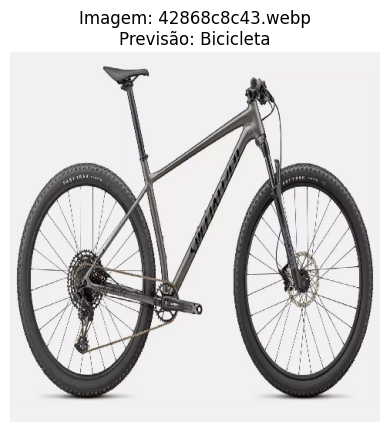

Probabilidades de cada classe: [9.8278922e-01 1.9875420e-03 4.2097477e-04 1.4802296e-02]
A classe prevista é: 'Bicicleta' com probabilidade de 0.98


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from google.colab import files
import io

# 1. Solicita o upload da imagem
uploaded = files.upload()

for filename in uploaded.keys():
    # 2. Lê a imagem do arquivo carregado
    img_bytes = uploaded[filename]
    img = image.load_img(io.BytesIO(img_bytes), target_size=(img_height, img_width))

    # 3. Pré-processa a imagem para a previsão
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) # Adiciona uma dimensão para o lote
    img_array /= 255.0 # Normaliza a imagem

    # 4. Faz a previsão
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])

    # Mapeia o índice da classe para o nome da classe
    class_labels = list(train_ds.class_indices.keys())
    predicted_class_name = class_labels[predicted_class_index]

    # 5. Exibe a imagem e o resultado da previsão
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Imagem: {filename}\nPrevisão: {predicted_class_name}")
    plt.show()

    print(f"Probabilidades de cada classe: {predictions[0]}")
    print(f"A classe prevista é: '{predicted_class_name}' com probabilidade de {predictions[0][predicted_class_index]:.2f}")